In [40]:
import csv
import numpy as np
import os
import random
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.cluster import KMeans, mean_shift

In [41]:
main_direct = '../resources/micro_proyecto1_data'
img_files = os.listdir(main_direct)
#PARAMETROS PRINCIPALES----------

#numero de clusters que se quieren
clusters = 7

#perplexity para T-SNET 
perplexityTSNET = 30

#resolusion
image_size = [1080,1080]
img_files

['ad-reinhardt_blue-painting-1953.jpg',
 'adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg',
 'albert-gleizes_la-chasse-1911.jpg',
 'albert-gleizes_portrait-de-jacques-nayral-1911.jpg',
 'aldemir-martins_yellow-cat-2001.jpg',
 'alfred-manessier_soir-e-d-octobre-1946.jpg',
 'alma-woodsey-thomas_starry-night-and-the-astronauts-1972.jpg',
 'andre-bauchant_cinq-personnages-dans-un-paysage-de-montagne-1953.jpg',
 'arman-manookian_ala-wai-honolulu-1928.jpg',
 'arman-manookian_shaman-1930.jpg',
 'barnett-newman_vir-heroicus-sublimis-1951.jpg',
 'claude-viallat_untitled-no-40-1996.jpg']

In [42]:
class LoadImages(BaseEstimator, TransformerMixin):
    def __init__(self, main_direct, file_names, target_size = image_size):
        self.main_direct = main_direct
        self.file_names = file_names
        self.target_size = target_size

    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None):
        image_list =  list()
        for file in self.file_names:
            img = cv2.imread(os.path.join(self.main_direct, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            image_list.append(img)
        return np.array(image_list)


In [43]:
class FlattenTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([img.reshape(-1, 3) for img in X])

In [44]:
class NormalizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Necesario para que funcione en Pipeline

    def transform(self,X):
        return np.array([img / 255.0 for img in X])

In [45]:
def plot_image_with_colors(original_images, colors, title):
    fig, axes = plt.subplots(1, 2, figsize=(30, 6)) 

    # Mostrar la imagen original    
    axes[0].imshow(original_images)
    axes[0].axis("off")
    axes[0].set_title(f"Imagen Original: {title} ")

    axes[1].imshow([colors])
    axes[1].axis("off")
    axes[1].set_title("Colores Dominantes")

    plt.show()

In [46]:
class ExecuteKmeans(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self


    def transform(self, X):

        all_dominant_colors = []
        for i, img in enumerate(X):
            kmeans = KMeans(n_clusters=clusters, random_state=42)
            kmeans.fit(img)
            dominant_colors = kmeans.cluster_centers_  # Obtener los colores principales
            all_dominant_colors.append(dominant_colors)
            print(f"colores dominantes: Imagen {i+1}")
            print(all_dominant_colors[i])
            plot_image_with_colors(original_images[i], dominant_colors, f"Imagen {i+1}")

        return np.array(all_dominant_colors)

In [47]:
class PCAImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pcas = []  # Lista para almacenar modelos PCA de cada imagen

    def fit(self, X, y=None):
        return self  # PCA no necesita un ajuste previo

    def transform(self, X):
        transformed_images = []

        for i, img in enumerate(X):  # Recorre cada imagen individualmente
            pca = PCA(n_components=self.n_components)
            img_pca = pca.fit_transform(img)  # Aplicamos PCA a la imagen

            self.pcas.append(pca)  # Guardamos el PCA de la imagen

            transformed_images.append(img_pca)  # Guardamos la imagen transformada
            print(f'Porcentaje de Varianza - Imagen {i+1}')
            print(pca.explained_variance_ratio_)
           
            plt.figure(figsize=(6, 4))
            plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
            plt.xlabel('Número de Componentes')
            plt.ylabel('Varianza Acumulada')
            plt.title(f'Varianza Acumulada - Imagen {i+1}')
            plt.grid()
            plt.show()
        return np.array(transformed_images)

In [48]:
class TSNETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, perplexity=10, random_state=42):
        self.n_components = n_components
        self.perplexity = perplexity
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        num_images, num_colors, num_features = X.shape
        X_reshaped = X.reshape(num_images * num_colors, num_features)
        labels = np.repeat(range(num_images), num_colors) 
        tsne = TSNE(n_components=self.n_components, perplexity=min(self.perplexity, X_reshaped.shape[0] - 1), random_state=self.random_state)
        tsne_result = tsne.fit_transform(X_reshaped)
        unique_labels = np.unique(labels)  
        palette = sns.color_palette("husl", len(unique_labels))  # Paleta de colores para cada imagen
        color_map = {label: palette[i] for i, label in enumerate(unique_labels)} 
        colors = [color_map[label] for label in labels]
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, alpha=0.7, edgecolors="k")

        legend_labels = [f"Imagen {i+1}" for i in unique_labels]
        legend_patches = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=palette[i], markersize=10) for i in range(len(unique_labels))]
        legend = plt.legend(legend_patches, legend_labels, title="Imágenes", loc="center left", bbox_to_anchor=(1, 0.5))

        plt.title("Distribución de Colores Dominantes con T-SNE")
        plt.grid(True)
        plt.show()

        return tsne_result

In [49]:
load_images_transformer = LoadImages(main_direct=main_direct, file_names=img_files)
original_images = load_images_transformer.transform(None)
print(original_images.shape)
original_images

(12, 1080, 1080, 3)


array([[[[ 28,  46,  72],
         [ 43,  60,  87],
         [ 47,  65,  92],
         ...,
         [ 29,  51,  98],
         [ 69,  90, 128],
         [180, 200, 232]],

        [[ 22,  47,  81],
         [ 26,  51,  85],
         [ 29,  54,  88],
         ...,
         [ 21,  44,  92],
         [ 67,  89, 129],
         [182, 205, 238]],

        [[ 13,  49,  92],
         [ 20,  56,  99],
         [ 20,  56, 100],
         ...,
         [ 23,  49,  99],
         [ 66,  90, 131],
         [180, 204, 238]],

        ...,

        [[238, 247, 234],
         [234, 246, 240],
         [238, 252, 252],
         ...,
         [ 13,  45, 126],
         [ 13,  47, 127],
         [ 13,  49, 127]],

        [[237, 248, 234],
         [234, 247, 241],
         [238, 252, 252],
         ...,
         [ 17,  51, 127],
         [ 18,  53, 128],
         [ 18,  54, 128]],

        [[239, 250, 236],
         [235, 248, 242],
         [236, 252, 252],
         ...,
         [ 17,  51, 123],
        

colores dominantes: Imagen 1
[[0.11750368 0.22911122 0.55640868]
 [0.03275112 0.18545788 0.60565144]
 [0.05814578 0.1947337  0.46196876]
 [0.80177617 0.88782137 0.94665267]
 [0.04790826 0.19118774 0.51561276]
 [0.1070923  0.23700134 0.62546484]
 [0.04886487 0.20152469 0.62615275]]


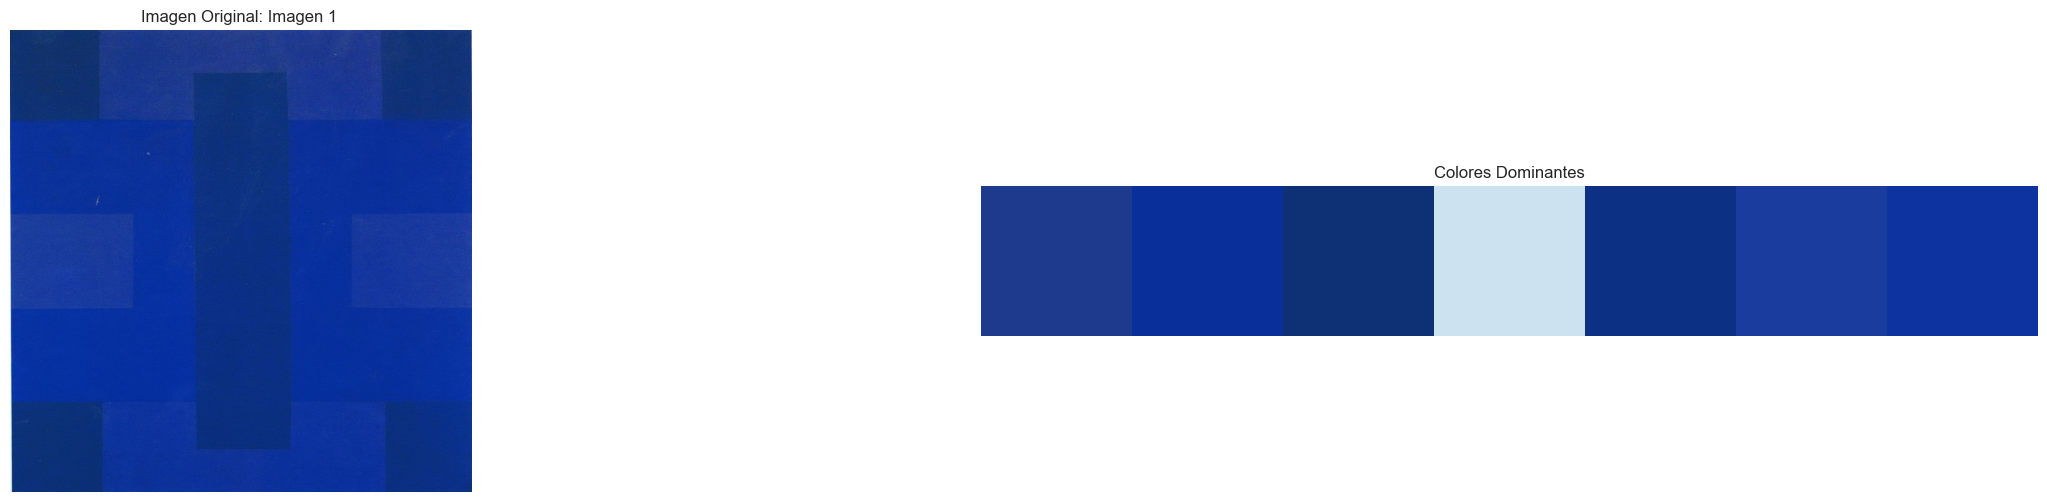

colores dominantes: Imagen 2
[[0.17861559 0.21645857 0.23870678]
 [0.72025892 0.4583901  0.32291316]
 [0.86180784 0.77194634 0.35101987]
 [0.43644459 0.47124882 0.46089592]
 [0.72985872 0.18856296 0.16786101]
 [0.7999677  0.59636817 0.46256891]
 [0.87159365 0.83004061 0.73930917]]


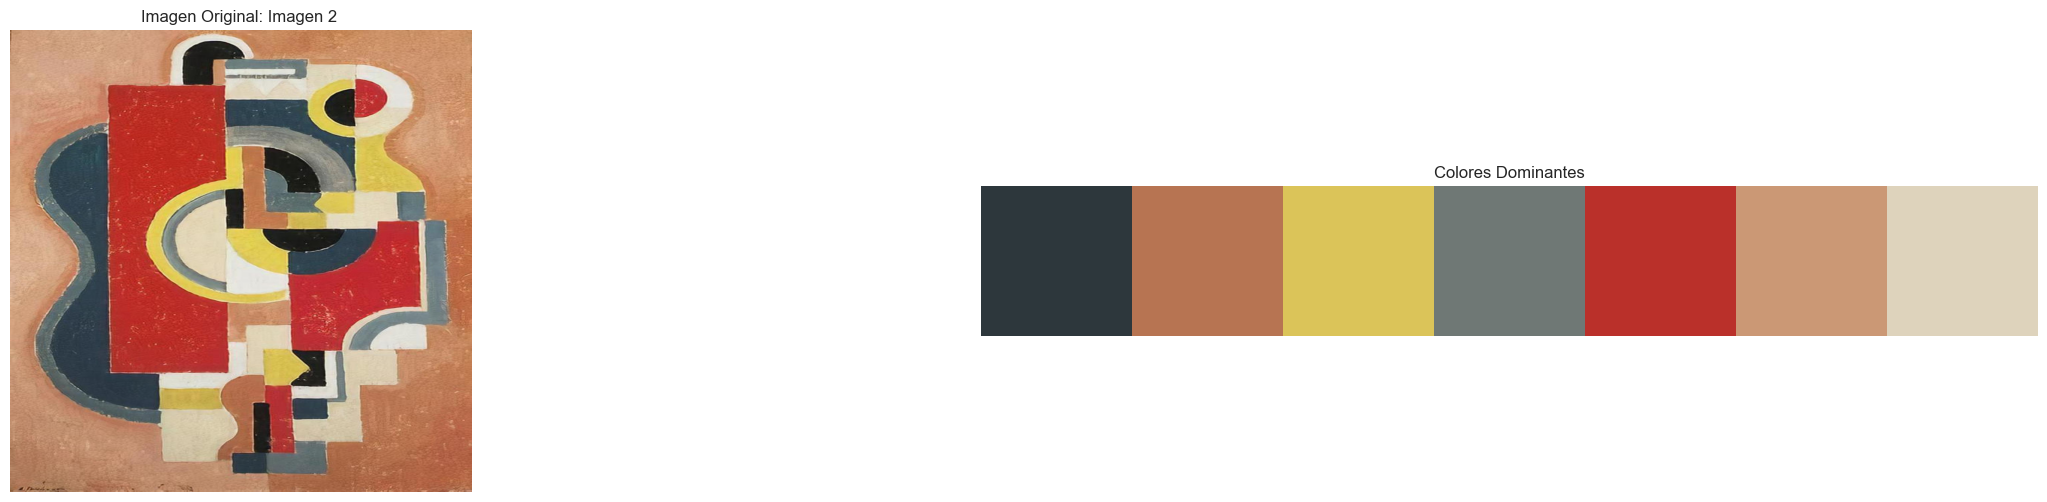

colores dominantes: Imagen 3
[[0.82261847 0.81801354 0.71315123]
 [0.23424661 0.2893621  0.23201265]
 [0.52957981 0.55714938 0.44532037]
 [0.12203892 0.14915571 0.12255964]
 [0.696846   0.36759825 0.24913645]
 [0.68867066 0.67401742 0.55057891]
 [0.38794717 0.41742024 0.33141426]]


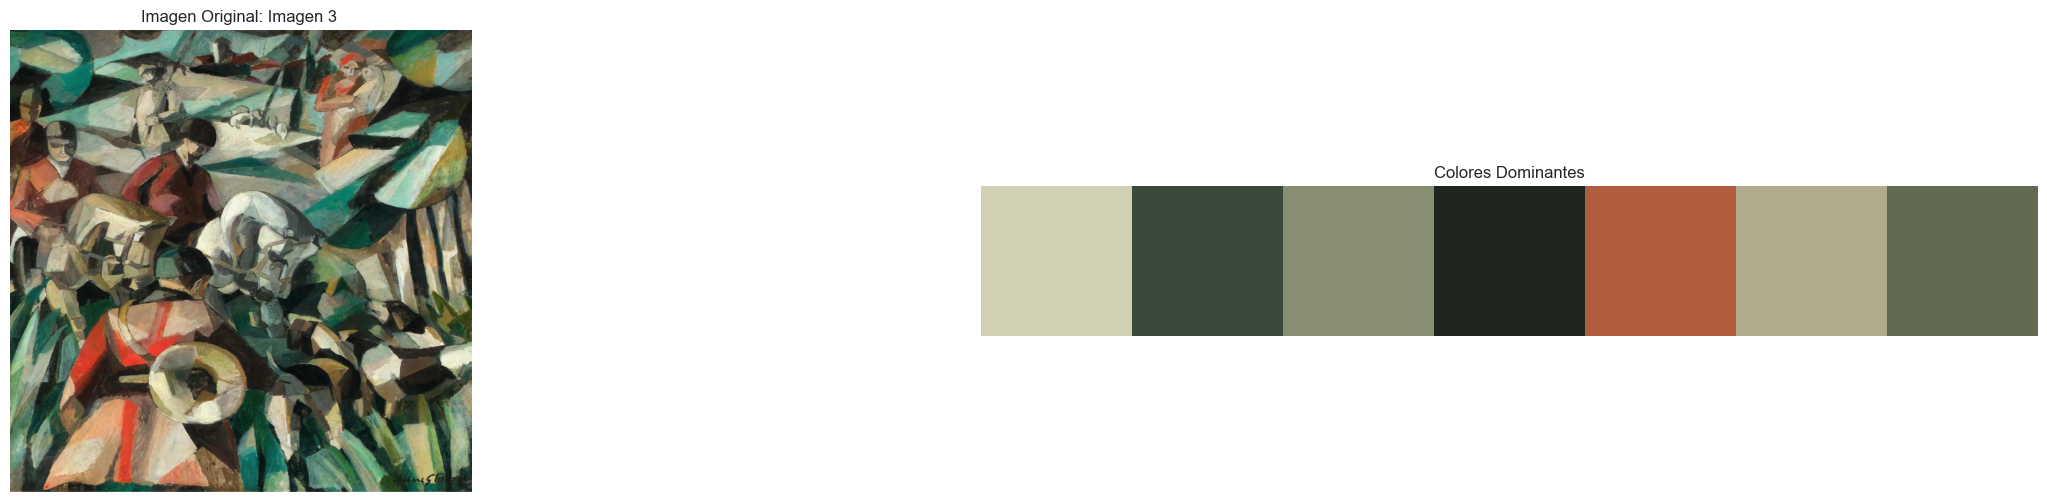

colores dominantes: Imagen 4
[[0.40410322 0.4406829  0.39948473]
 [0.1026532  0.15933743 0.16140124]
 [0.6135769  0.64155835 0.60994212]
 [0.18965022 0.25539909 0.24557949]
 [0.30122742 0.35087754 0.31813346]
 [0.5029435  0.53482125 0.50135231]
 [0.75324274 0.76484402 0.74193752]]


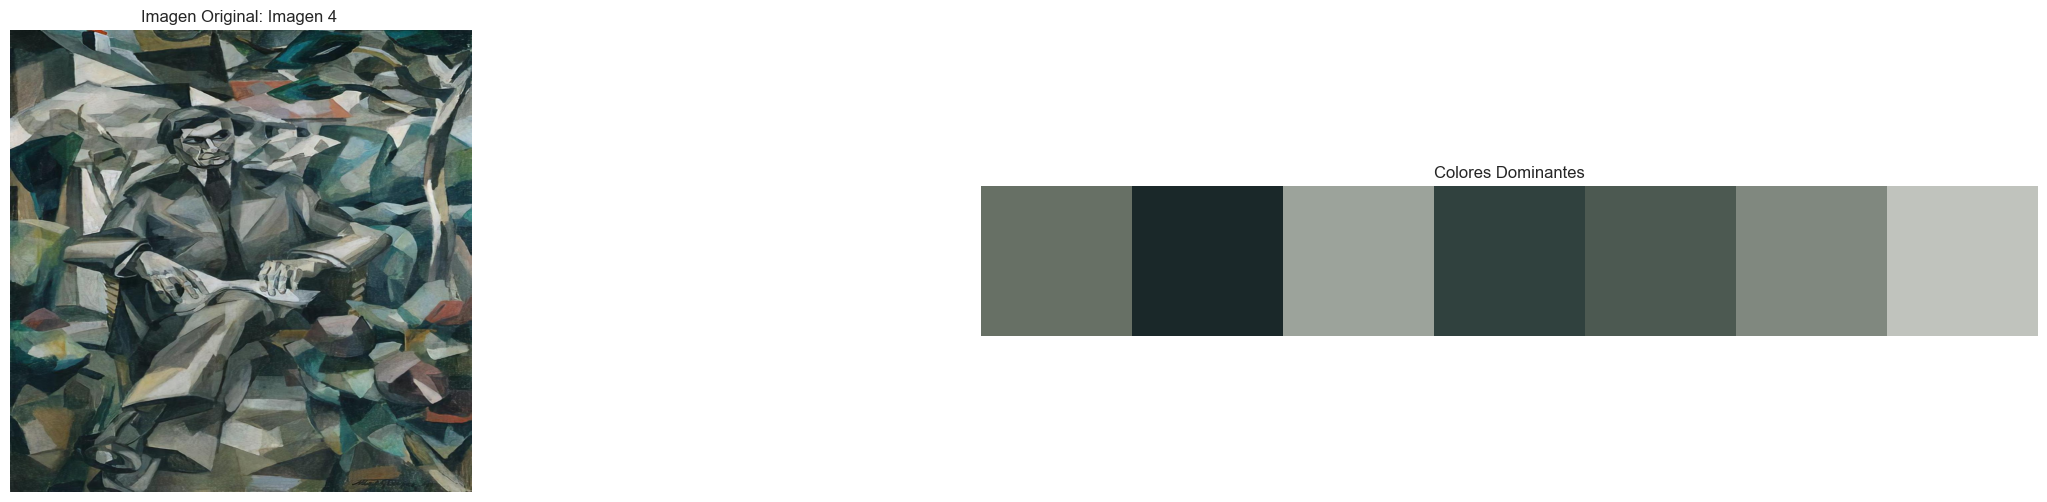

colores dominantes: Imagen 5
[[0.96472082 0.84680152 0.20907499]
 [0.32221435 0.17021186 0.13591392]
 [0.32802331 0.38505051 0.45866426]
 [0.91950653 0.68626774 0.20763077]
 [0.97255816 0.95546093 0.78974633]
 [0.21377398 0.27964273 0.30107448]
 [0.78670357 0.2600042  0.13488674]]


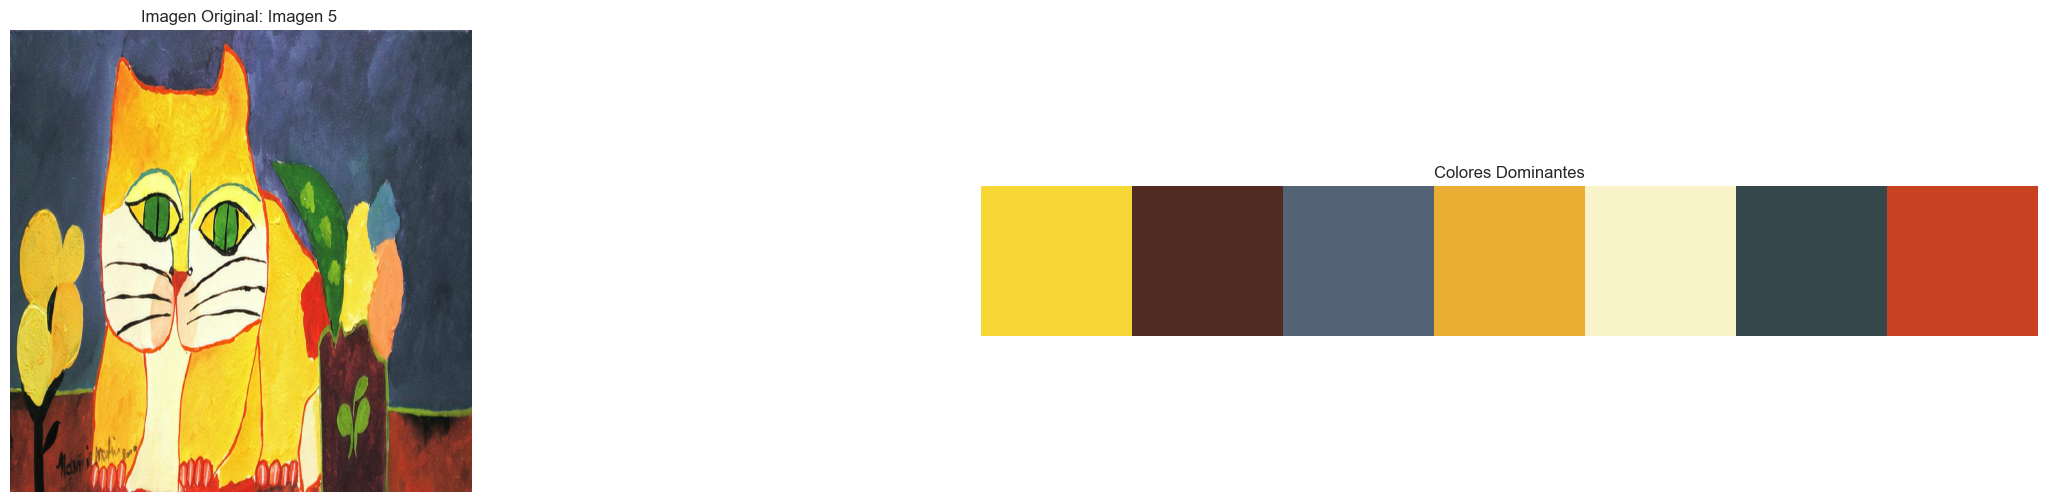

colores dominantes: Imagen 6
[[0.56201812 0.38376026 0.35882299]
 [0.76661657 0.71423913 0.65563979]
 [0.80248862 0.52932062 0.4520898 ]
 [0.30367625 0.28903079 0.29313137]
 [0.32898354 0.47039257 0.52664194]
 [0.77465502 0.38708081 0.2971357 ]
 [0.90102297 0.62160965 0.26079825]]


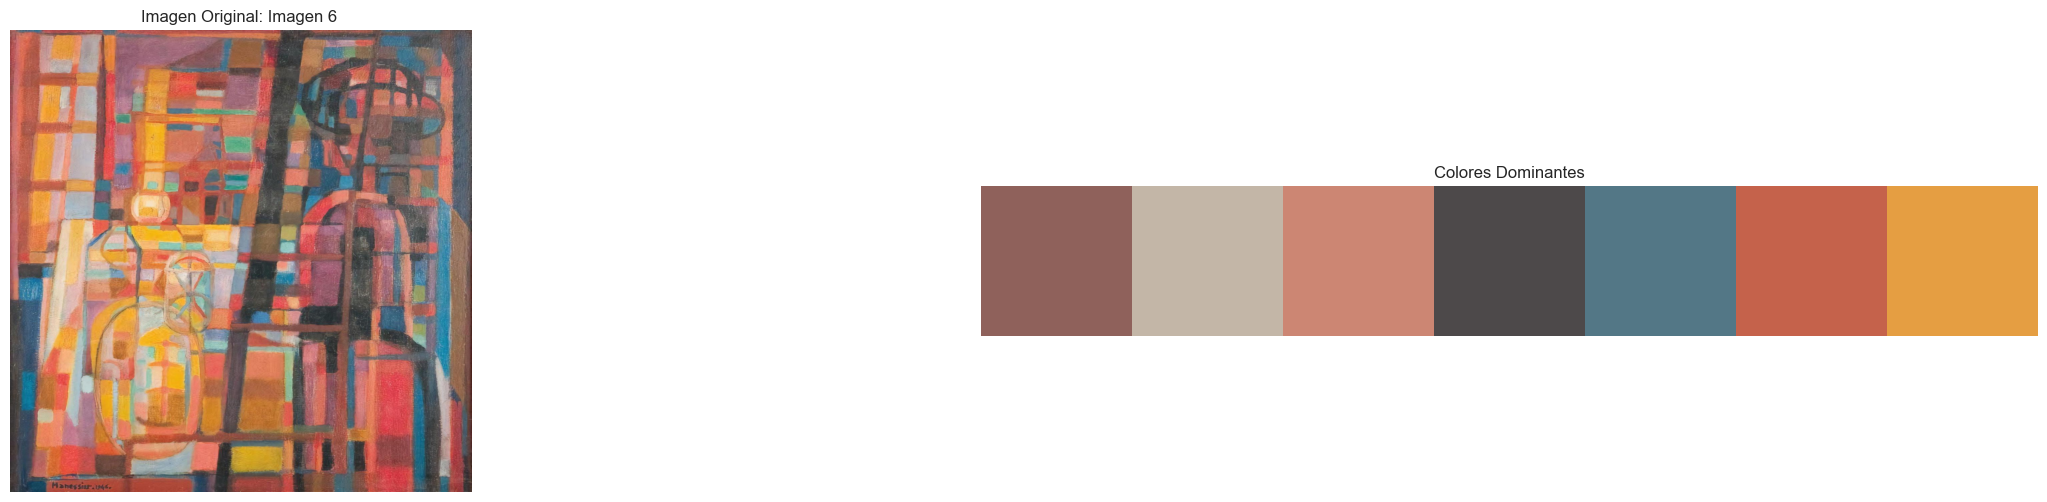

colores dominantes: Imagen 7
[[0.11844447 0.30412712 0.49960925]
 [0.8567335  0.90639274 0.90937571]
 [0.05644533 0.11032144 0.19731985]
 [0.12269394 0.44745069 0.67393063]
 [0.08172973 0.18604367 0.33964911]
 [0.75280993 0.40142812 0.15818017]
 [0.49687062 0.61205248 0.70217373]]


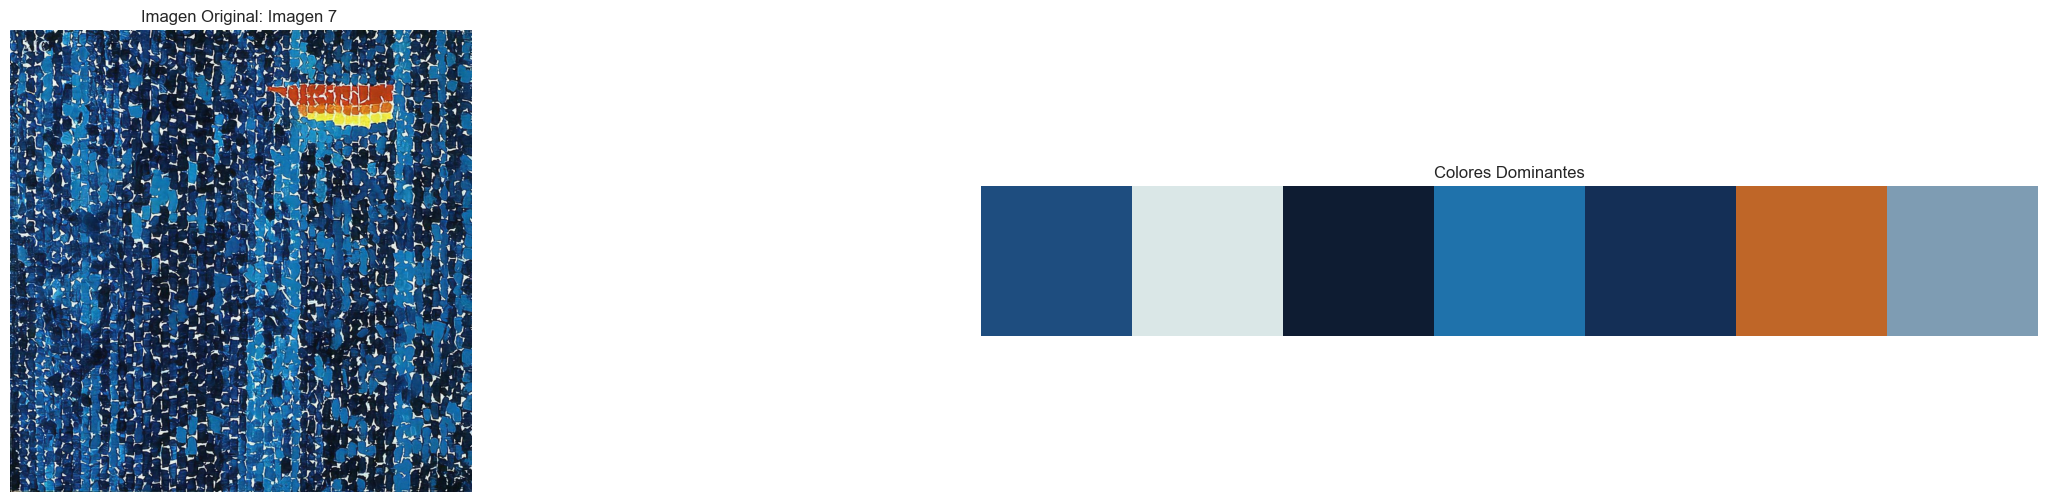

colores dominantes: Imagen 8
[[0.59190525 0.57506662 0.48117991]
 [0.4290098  0.47074021 0.27649869]
 [0.6622909  0.73350794 0.74111077]
 [0.34446219 0.35583346 0.25441375]
 [0.50130311 0.55073111 0.35699821]
 [0.76391539 0.78286382 0.74292653]
 [0.70579474 0.67459372 0.6000946 ]]


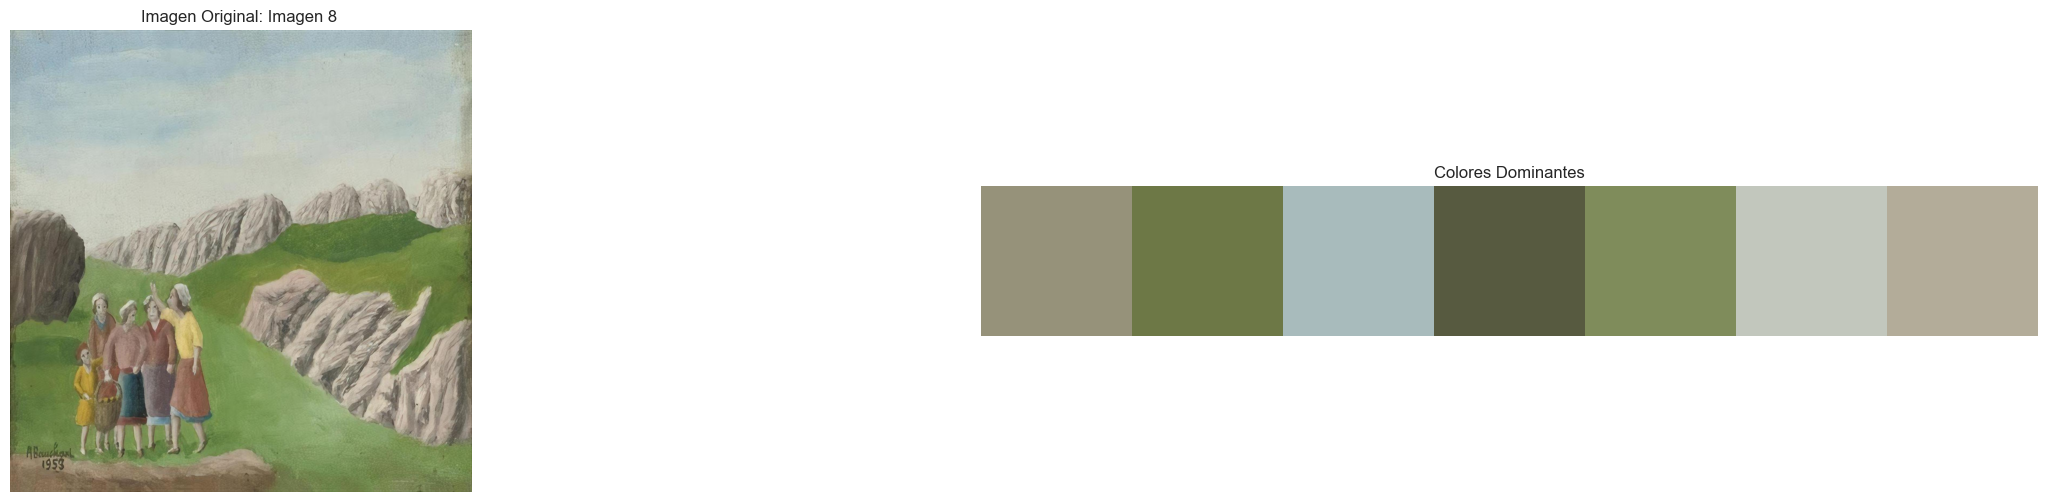

colores dominantes: Imagen 9
[[0.24377679 0.29648404 0.30629721]
 [0.93914651 0.72081059 0.20032244]
 [0.91875191 0.89201439 0.84174648]
 [0.4438445  0.67110254 0.77905298]
 [0.88732511 0.45602309 0.39425658]
 [0.44767171 0.48919378 0.47660434]
 [0.85238943 0.79921569 0.53736773]]


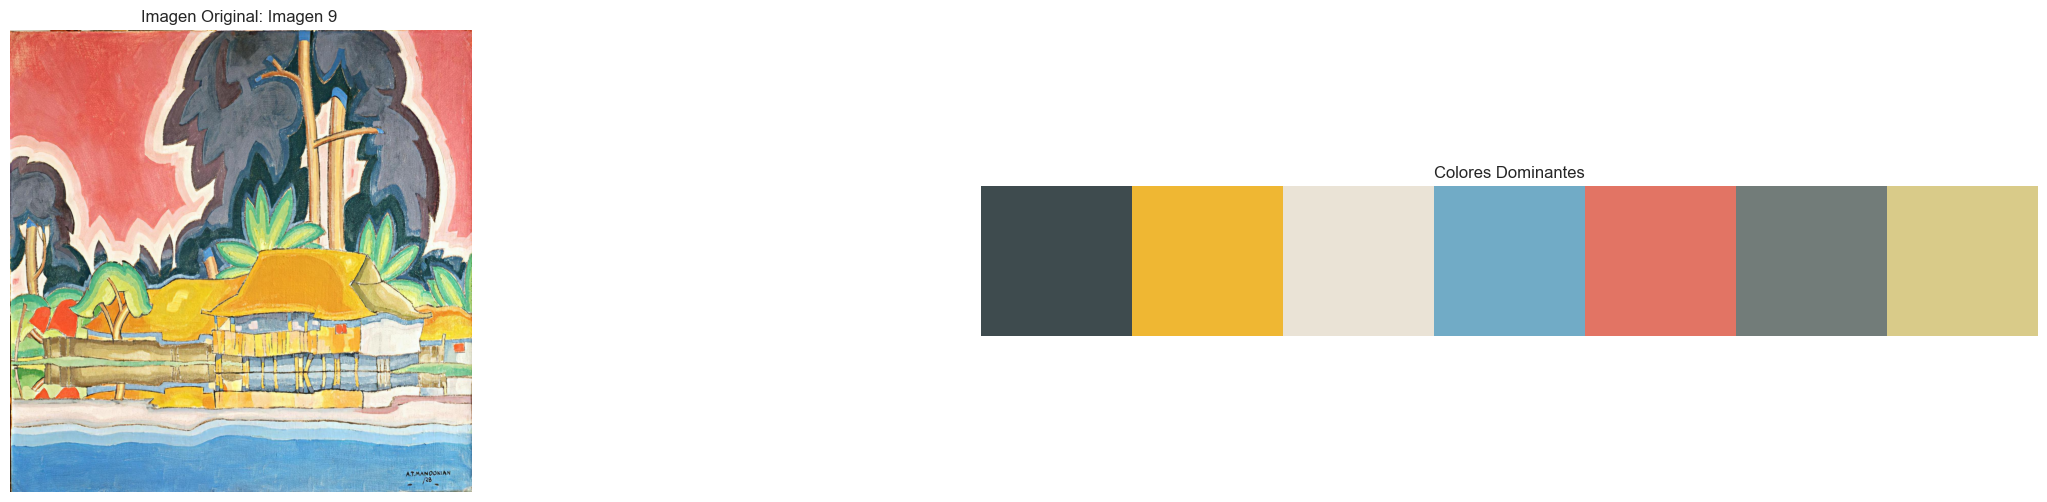

colores dominantes: Imagen 10
[[0.75546062 0.76200283 0.74403446]
 [0.54947078 0.26177016 0.22524639]
 [0.52235739 0.50748408 0.52365027]
 [0.19750879 0.17196351 0.21118926]
 [0.65581551 0.61265137 0.68034023]
 [0.33820852 0.52409229 0.7385412 ]
 [0.32707253 0.27452289 0.38842309]]


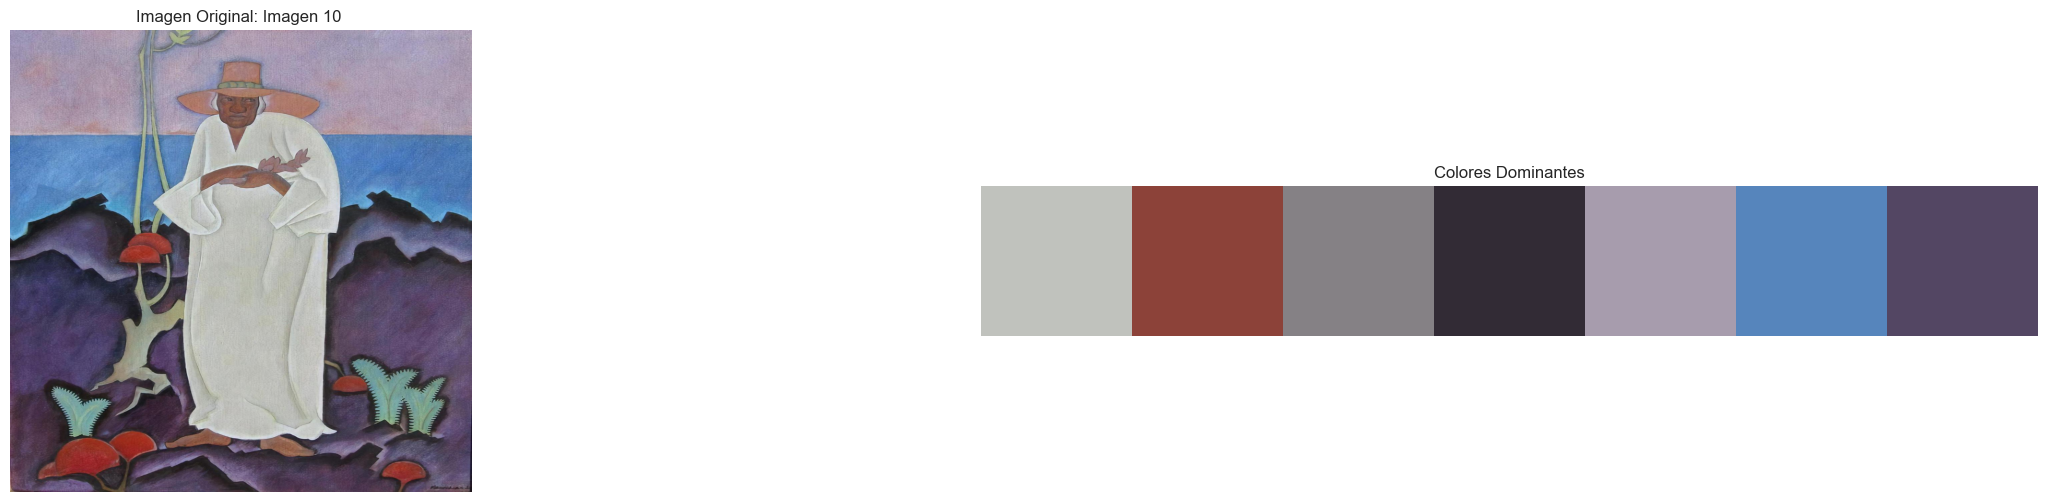

colores dominantes: Imagen 11
[[0.86085619 0.17176271 0.11671478]
 [0.6928828  0.09527644 0.083744  ]
 [0.76963696 0.11128368 0.07437768]
 [0.86371422 0.63179536 0.50157223]
 [0.82463552 0.13841224 0.0874323 ]
 [0.83600832 0.51212181 0.30598169]
 [0.75375278 0.13975252 0.12118401]]


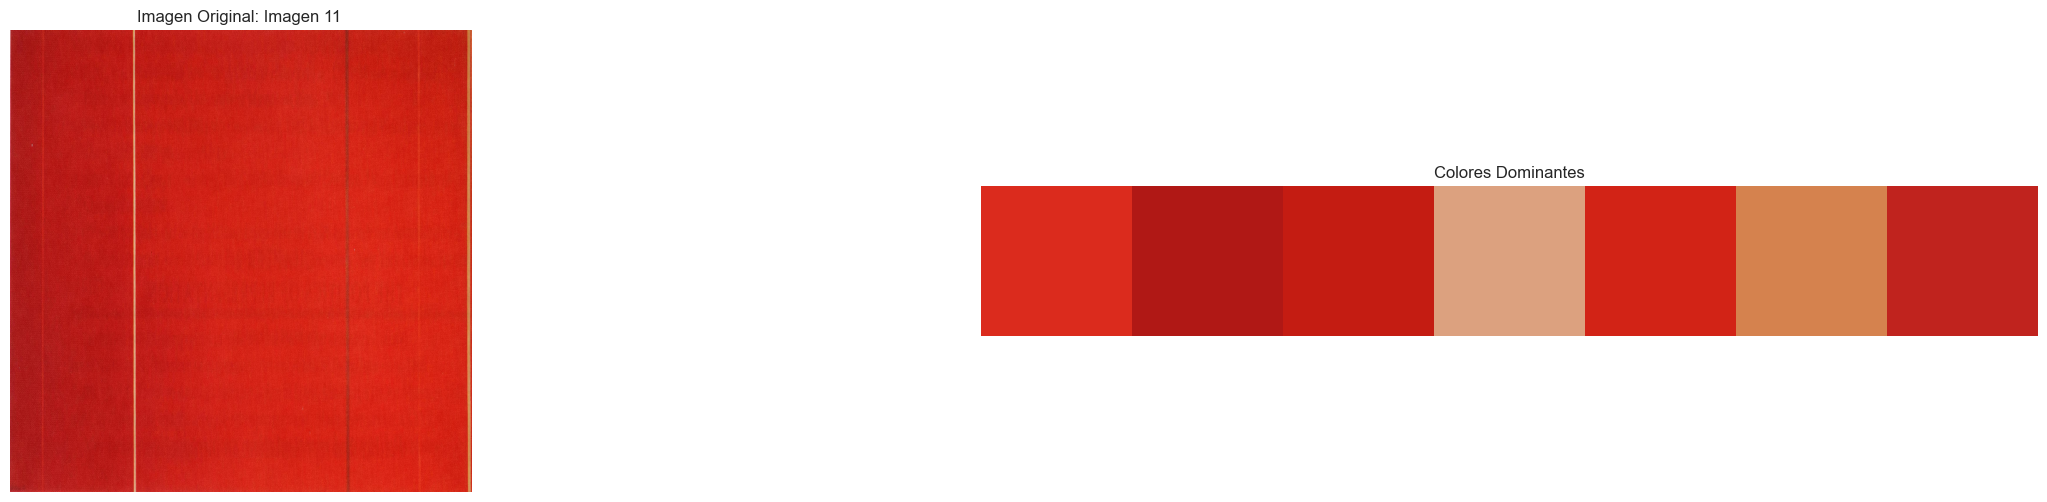

colores dominantes: Imagen 12
[[0.84515138 0.74076566 0.29984891]
 [0.94099797 0.93121894 0.88621184]
 [0.83074957 0.77979522 0.6211022 ]
 [0.69564112 0.57544827 0.22992124]
 [0.73886305 0.67164395 0.48568472]
 [0.85807856 0.83093629 0.75076313]
 [0.76853744 0.65076258 0.26582654]]


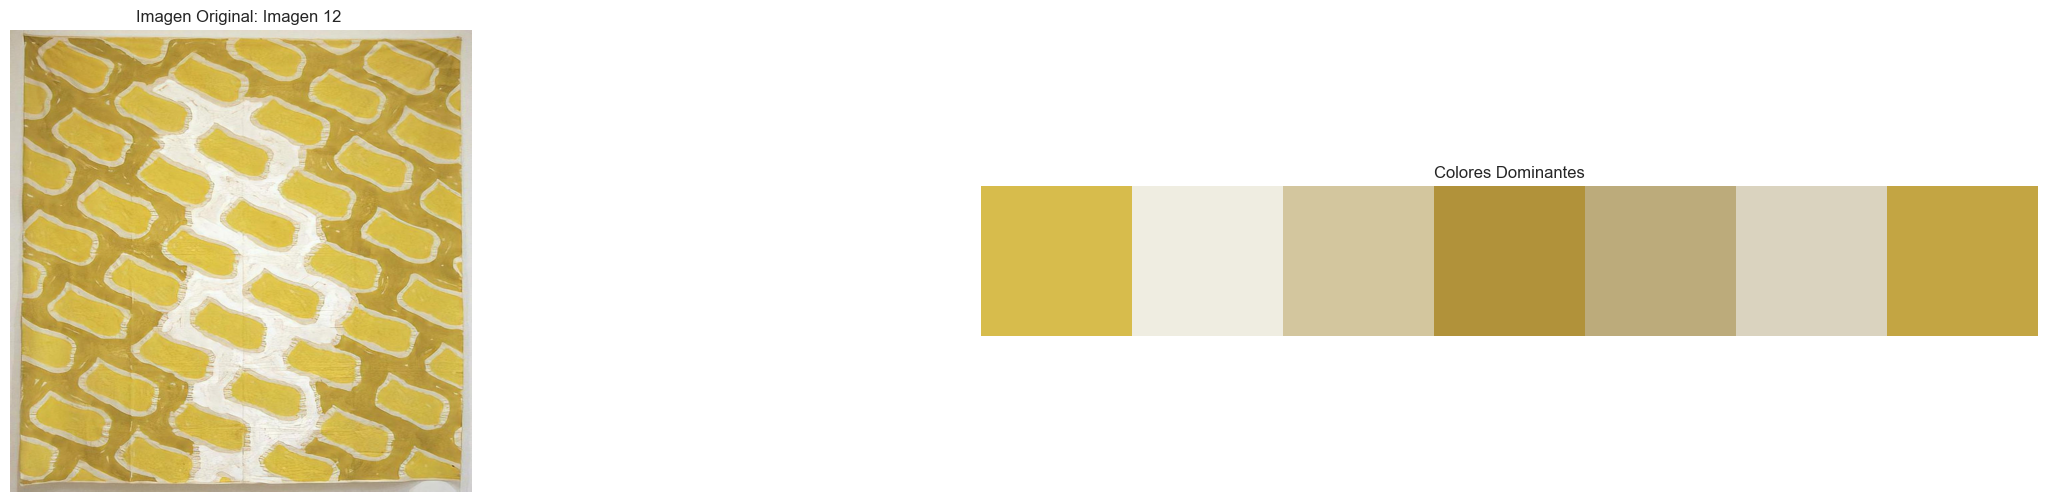

Porcentaje de Varianza - Imagen 1
[0.98122902 0.01840637]


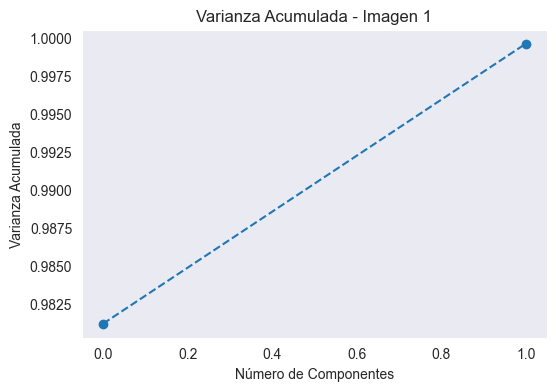

Porcentaje de Varianza - Imagen 2
[0.76485594 0.19635778]


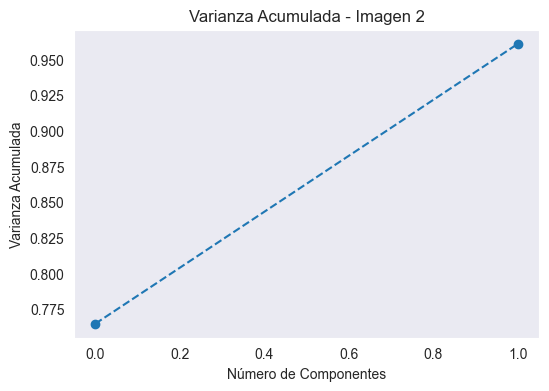

Porcentaje de Varianza - Imagen 3
[0.91905843 0.08022215]


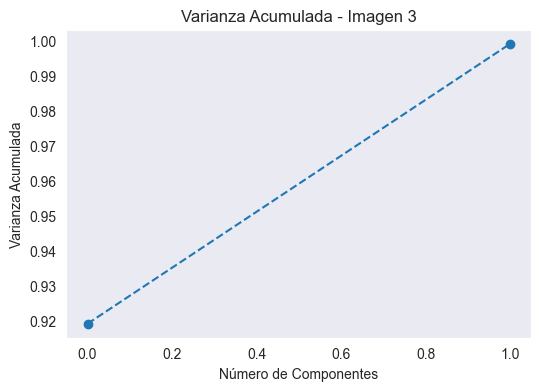

Porcentaje de Varianza - Imagen 4
[9.99097106e-01 8.04743762e-04]


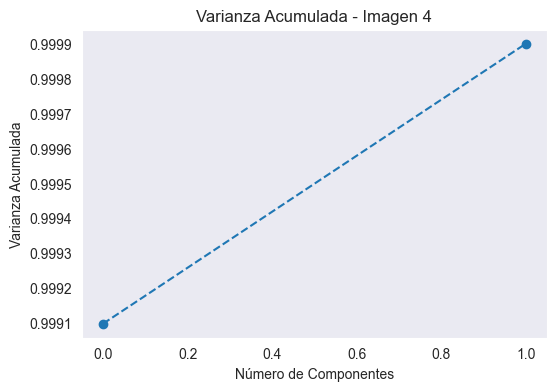

Porcentaje de Varianza - Imagen 5
[0.75422208 0.21199411]


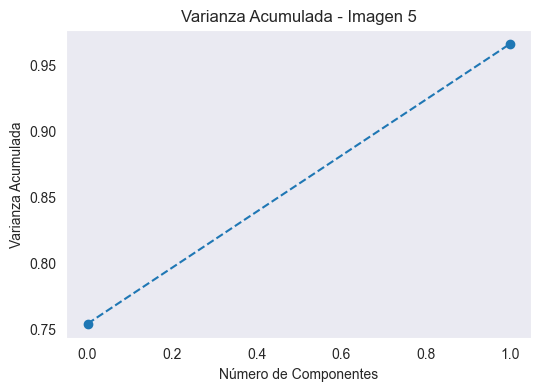

Porcentaje de Varianza - Imagen 6
[0.68623421 0.2854313 ]


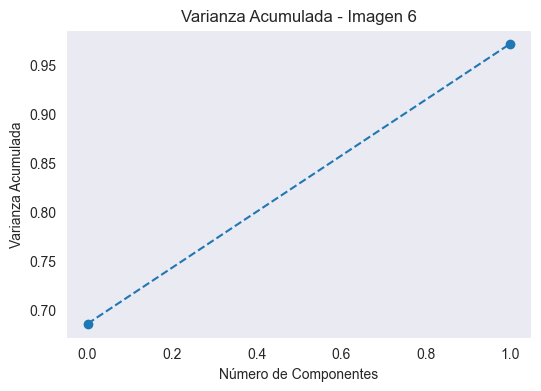

Porcentaje de Varianza - Imagen 7
[0.76267058 0.2369629 ]


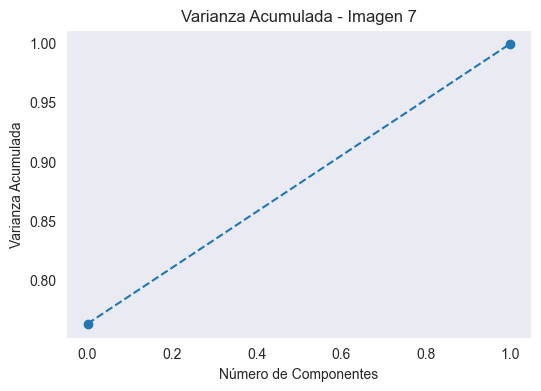

Porcentaje de Varianza - Imagen 8
[0.97219541 0.02135764]


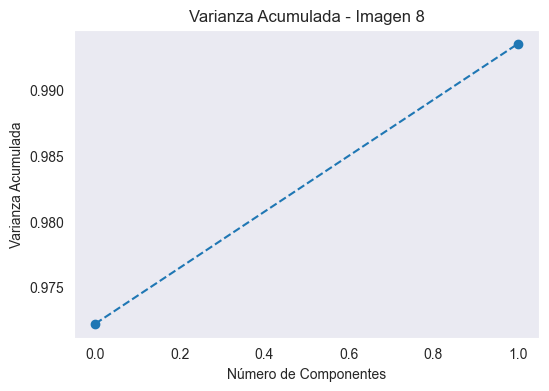

Porcentaje de Varianza - Imagen 9
[0.62432756 0.33545162]


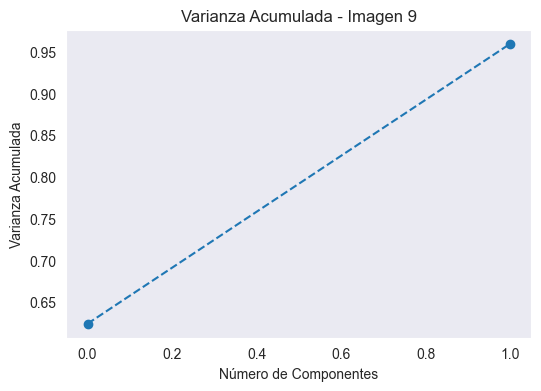

Porcentaje de Varianza - Imagen 10
[0.84226676 0.15277913]


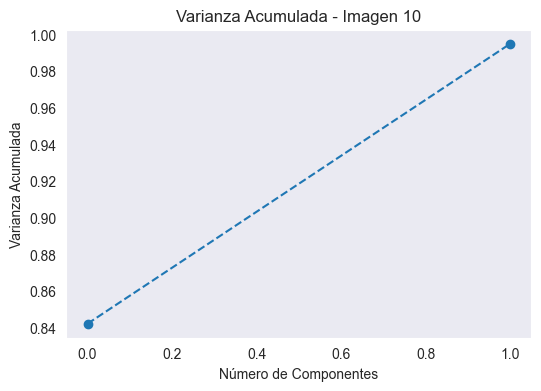

Porcentaje de Varianza - Imagen 11
[0.95834541 0.03292599]


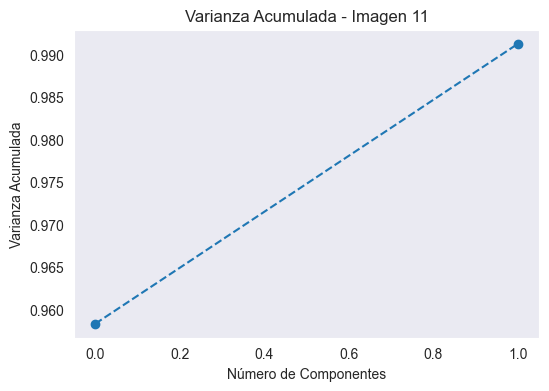

Porcentaje de Varianza - Imagen 12
[0.9524801  0.04742785]


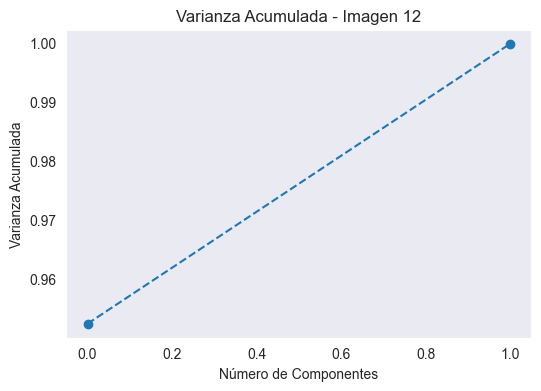

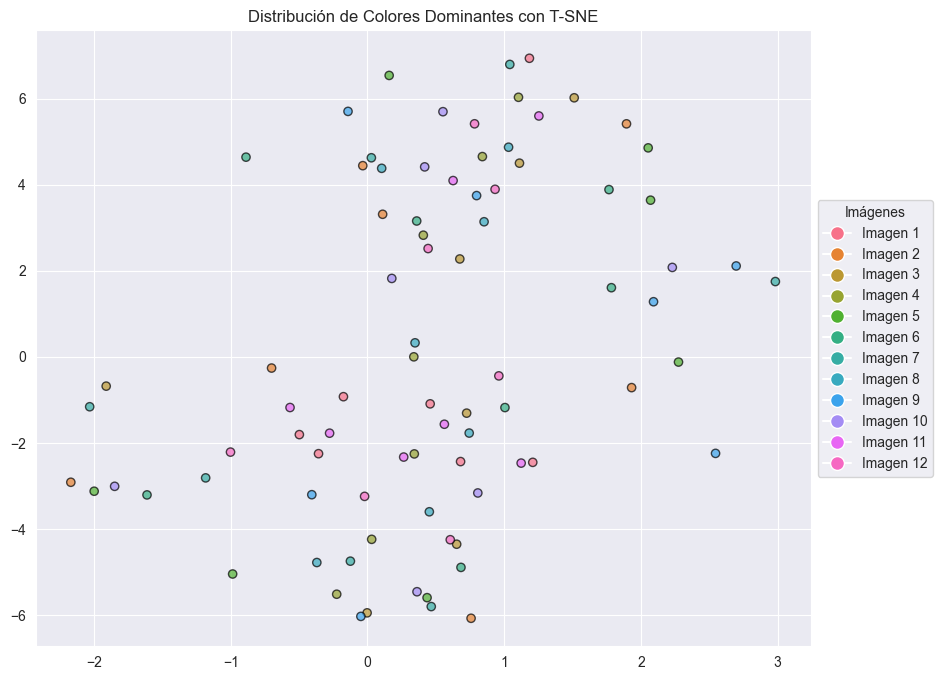

In [50]:
image_pipeline = Pipeline([
    ("load_images", LoadImages(main_direct = main_direct, file_names = img_files )),
    ("flatten", FlattenTransformer()),
    ("normalize", NormalizeTransformer()),
    ("kmeans_and_show", ExecuteKmeans()),
    ("pca_per_image", PCAImageTransformer(n_components=2)),
    ("tsne_per_image", TSNETransformer(n_components=2, perplexity= perplexityTSNET, random_state=42))
])
processed_images = image_pipeline.fit_transform(None)

In [51]:
processed_images

array([[ 4.58437979e-01, -1.09060705e+00],
       [-3.57880145e-01, -2.24832106e+00],
       [ 1.20858479e+00, -2.44939303e+00],
       [ 1.18408656e+00,  6.93732166e+00],
       [ 6.80745184e-01, -2.43150449e+00],
       [-1.75759062e-01, -9.24192071e-01],
       [-4.98050749e-01, -1.80500269e+00],
       [ 7.57529736e-01, -6.07182455e+00],
       [-7.01162040e-01, -2.58970350e-01],
       [-3.42438295e-02,  4.44273758e+00],
       [ 1.93139756e+00, -7.13296413e-01],
       [-2.16911602e+00, -2.91207600e+00],
       [ 1.10940434e-01,  3.31349206e+00],
       [ 1.89397216e+00,  5.41433716e+00],
       [ 1.51160157e+00,  6.01927519e+00],
       [ 6.52206242e-01, -4.35121107e+00],
       [ 6.75195396e-01,  2.27531338e+00],
       [-2.67615658e-03, -5.94590092e+00],
       [-1.91052306e+00, -6.78916991e-01],
       [ 1.11145520e+00,  4.50089693e+00],
       [ 7.25116134e-01, -1.30633092e+00],
       [ 3.38920027e-01,  1.63731782e-03],
       [-2.24944815e-01, -5.51285839e+00],
       [ 8.